In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from collections import Counter
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [31]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [32]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [33]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


In [34]:
genre_books.groupby('title').count()

,author,date,summary,genre
title,,,,
...And Call Me Conrad,1,1,1,1
...And Now Miguel,1,1,1,1
.hack//AI buster,1,1,1,1
.hack//AI buster 2,1,1,1,1
.hack//Another Birth,1,1,1,1
...,...,...,...,...
"\\""U\\"" Is for Undertow",1,1,1,1
"\\""V\\"" Is for Vengeance",1,1,1,1
e,1,1,1,1


In [35]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [36]:
genre_books.describe()

,title,author,date,summary,genre
count,8954,8954,8954,8954,8954
unique,8869,2698,1920,8934,5
top,The Chosen,,,~Plot outline description~ --> <!--,Fantasy
freq,3,447,2070,12,2311


In [37]:
genre_books.dtypes

title      object
author     object
date       object
summary    object
genre      object
dtype: object

## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [38]:
genre_books['title'] = pd.Categorical(genre_books['title'])
genre_books['author'] = pd.Categorical(genre_books['author'])
genre_books['date'] = pd.Categorical(genre_books['date'])
genre_books['summary'] = pd.Categorical(genre_books['summary'])
genre_books['genre'] = pd.Categorical(genre_books['genre'])
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [39]:
print("counting the number of words.")
genre_books['number_of_words'] = genre_books['summary'].apply(lambda x: len(str(x).split(" ")))
genre_books.head()

counting the number of words.


,title,author,date,summary,genre,number_of_words
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067


In [40]:
print("The Number of sentence in the summary")
genre_books['number_of_sentence'] = genre_books['summary'].apply(lambda x: len(str(x).split(".")))
genre_books.head()

The Number of sentence in the summary


,title,author,date,summary,genre,number_of_words,number_of_sentence
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53


In [41]:
genre_books['count_char'] = genre_books['summary'].str.len()
genre_books[['summary', 'count_char']].head()

,summary,count_char
0,"Old Major, the old boar on the Manor Farm, ca...",5812
1,"Alex, a teenager living in near-future Englan...",6121
2,The text of The Plague is divided into five p...,6642
4,The novel posits that space around the Milky ...,4493
6,"Ged is a young boy on Gont, one of the larger...",5850


In [42]:
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850


In [43]:
def missing_data(df):
    t = df.isnull().sum().sort_values(ascending=False)
    p = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    d = pd.concat([t, p], axis=1, keys=['Total', 'Percentage'])
    return d

In [44]:
missing_data(genre_books)

,Total,Percentage
count_char,0,0.0
number_of_sentence,0,0.0
number_of_words,0,0.0
genre,0,0.0
summary,0,0.0
date,0,0.0
author,0,0.0
title,0,0.0


In [45]:
genre_books.dtypes

title                 category
author                category
date                  category
summary               category
genre                 category
number_of_words          int64
number_of_sentence       int64
count_char               int64
dtype: object

In [46]:
print("There is nothing to drop.")

There is nothing to drop.


In [47]:
genre_books['avg_words'] = genre_books['summary'].apply(lambda x: (len(str(x).split(" "))/(len(str(x).split(".")))))
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char,avg_words
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812,18.423077
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121,21.255319
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642,16.000000
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493,23.322581
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850,20.132075


In [48]:
genre_books['letter_a'] = genre_books['summary'].apply(lambda x: x.count('a'))
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char,avg_words,letter_a
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812,18.423077,452
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121,21.255319,380
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642,16.000000,416
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493,23.322581,300
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850,20.132075,382


In [49]:
genre_books['count_dot'] = genre_books['summary'].apply(lambda x: x.count('.'))
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char,avg_words,letter_a,count_dot
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812,18.423077,452,51
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121,21.255319,380,46
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642,16.000000,416,69
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493,23.322581,300,30
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850,20.132075,382,52


In [50]:
genre_books['count_cap'] = genre_books['summary'].apply(lambda x: x.count('T'))
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char,avg_words,letter_a,count_dot,count_cap
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812,18.423077,452,51,14
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121,21.255319,380,46,13
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642,16.000000,416,69,20
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493,23.322581,300,30,26
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850,20.132075,382,52,17


In [158]:
vectorizer = TfidfVectorizer(max_features = 100)
X = vectorizer.fit_transform(genre_books.summary).toarray()
print(X.shape)

(8954, 100)


In [159]:
print(vectorizer.get_feature_names())

['about', 'after', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'book', 'but', 'by', 'can', 'death', 'during', 'family', 'father', 'find', 'finds', 'first', 'for', 'from', 'go', 'had', 'has', 'have', 'he', 'help', 'her', 'him', 'himself', 'his', 'home', 'house', 'however', 'in', 'into', 'is', 'it', 'its', 'later', 'life', 'man', 'more', 'mother', 'new', 'no', 'not', 'novel', 'now', 'of', 'off', 'old', 'on', 'one', 'only', 'or', 'other', 'out', 'over', 'own', 'people', 'she', 'so', 'some', 'story', 'take', 'takes', 'tells', 'that', 'the', 'their', 'them', 'then', 'there', 'they', 'this', 'through', 'time', 'to', 'two', 'up', 'was', 'way', 'what', 'when', 'where', 'which', 'while', 'who', 'will', 'with', 'world', 'years']


In [161]:
genre_books_mean = genre_books.groupby(['genre']).mean()
genre_books_mean

,number_of_words,number_of_sentence,count_char,avg_words,letter_a,count_dot,count_cap
genre,,,,,,,
Children's literature,392.824176,21.610806,2225.768315,18.117246,143.656593,20.610806,6.610806
Fantasy,543.366508,26.729987,3135.123323,20.493533,209.339680,25.729987,10.310688
Mystery,410.944842,21.305874,2392.829513,19.487972,155.490688,20.305874,6.146848
Novel,434.163419,22.408769,2547.375996,19.955820,167.594774,21.408769,7.260407
Science Fiction,439.230364,21.186083,2609.856089,19.752621,173.312072,20.186083,8.037955


In [168]:
dist = pdist(X, 'euclidean')
linkage_matrix = linkage(dist, method = 'complete')

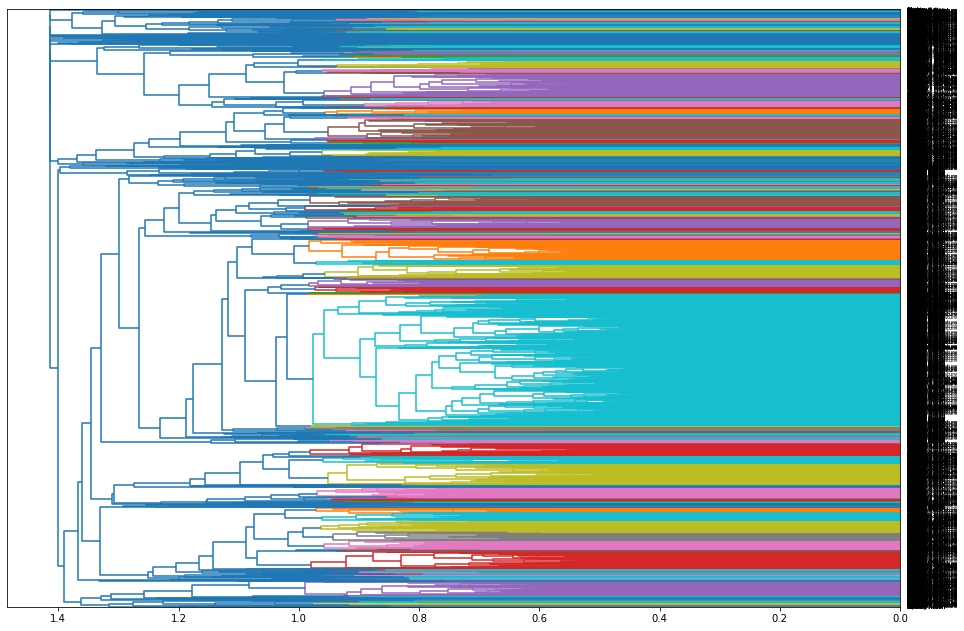

In [170]:
plt.figure(figsize=(16, 11))
dendrogram(linkage_matrix, labels = list(genre_books.genre), orientation= 'left')
plt.show()

## Model Training

Then, train two predictive models from the given data set.

In [51]:
genre_books.describe()

,number_of_words,number_of_sentence,count_char,avg_words,letter_a,count_dot,count_cap
count,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000
mean,454.760331,22.995756,2648.991624,19.754385,174.773732,21.995756,7.959571
std,516.476706,26.526064,2983.866246,6.000391,198.088700,26.526064,10.840514
min,2.000000,1.000000,11.000000,2.000000,0.000000,0.000000,0.000000
25%,127.000000,7.000000,741.000000,16.363636,48.000000,6.000000,2.000000
50%,291.000000,14.000000,1706.000000,19.500000,112.000000,13.000000,4.000000
75%,609.000000,30.000000,3553.000000,22.726489,236.000000,29.000000,10.000000
max,10335.000000,507.000000,58019.000000,261.333333,3649.000000,506.000000,263.000000


In [54]:
genre_books.shape

(8954, 12)

In [83]:
def genre_to_numeric(x):
    if x == "Children's literature": return 1
    if x == 'Fantasy': return 2
    if x == 'Mystery': return 3
    if x == 'Novel': return 4
    if x == 'Science Fiction': return 5
genre_books['genre_num'] = genre_books['genre'].apply(genre_to_numeric)
genre_books.head()

,title,author,date,summary,genre,number_of_words,number_of_sentence,count_char,avg_words,letter_a,count_dot,count_cap,genre_num
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,958,52,5812,18.423077,452,51,14,1
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,999,47,6121,21.255319,380,46,13,4
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,1120,70,6642,16.000000,416,69,20,4
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,723,31,4493,23.322581,300,30,26,2
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1067,53,5850,20.132075,382,52,17,2


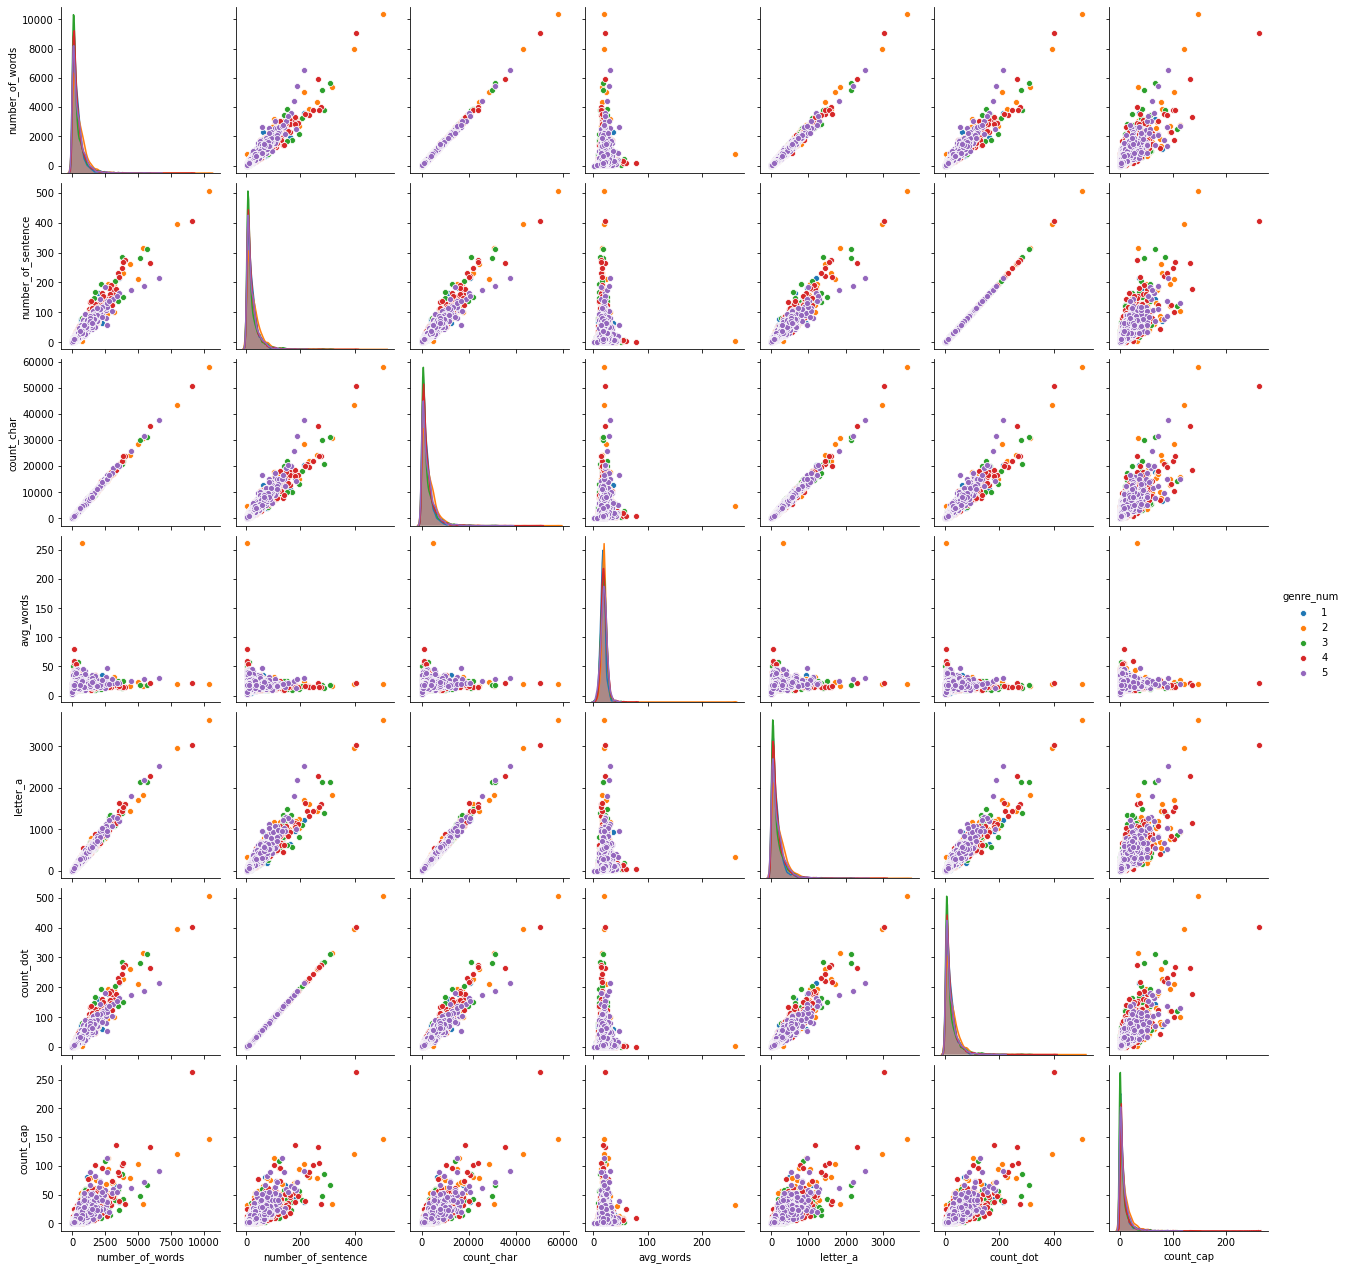

In [92]:
sns.pairplot(genre_books, hue='genre_num')

In [84]:
genre_books.isna().sum()

title                 0
author                0
date                  0
summary               0
genre                 0
number_of_words       0
number_of_sentence    0
count_char            0
avg_words             0
letter_a              0
count_dot             0
count_cap             0
genre_num             0
dtype: int64

In [85]:
genre_book = genre_books.dropna()
print(genre_book.shape)

(8954, 13)


In [122]:
train, test = train_test_split(genre_book, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(7163, 13)
(1791, 13)


In [123]:
trans_text = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=100)

In [124]:
x_train = trans_text.fit_transform(train['summary'])
x_test = trans_text.fit_transform(test['summary'])
print(x_train.shape)
print(x_test.shape)

(7163, 100)
(1791, 100)


In [139]:
y_train = train['genre_num']
y_test = test['genre_num']

In [140]:
model = LogisticRegression()

In [141]:
model.fit(x_train, y_train)

LogisticRegression()

In [142]:
y_train_hat = model.predict(x_train)
print(y_train_hat)

[4 1 2 ... 4 5 4]


In [143]:
y_train

16377    2
10804    3
10415    5
15205    2
15389    2
        ..
10351    5
8380     2
12512    5
12356    5
461      4
Name: genre_num, Length: 7163, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

In [144]:
y_test_hat = model.predict(x_test)
y_test_hat

array([2, 4, 3, ..., 4, 2, 2], dtype=int64)

## Model Evaluation

Finally, evaluate and compare the learned predictive models.

In [145]:
print("Accuracy score on training set: ", accuracy_score(y_train, y_train_hat))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_test_hat))

Accuracy score on training set:  0.5553539019963702
Accuracy score on testing set:  0.42825237297599106


In [157]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           1       0.40      0.22      0.28       237
           2       0.41      0.51      0.46       453
           3       0.30      0.32      0.31       271
           4       0.41      0.46      0.44       430
           5       0.60      0.51      0.55       400

    accuracy                           0.43      1791
   macro avg       0.42      0.40      0.41      1791
weighted avg       0.43      0.43      0.43      1791



In [179]:
models = [('LR', LogisticRegression()), ('SVM', SVC()), ('DT', DecisionTreeClassifier()), ('KNN', KNeighborsClassifier()), ('LD', LinearDiscriminantAnalysis()), ('GB', GaussianNB())]

In [206]:
out = []
mode = []

for model_name, model in models:
    k_fold = model_selection.KFold(n_splits=10, random_state=12)
    results = model_selection.cross_val_score(model, x_train, y_train, cv=k_fold, scoring='accuracy')
    out.append(results)
    mode.append(model_name)
    output = "%s| Mean=%f STD=%f" %(model_name, results.mean(), results.std())
    print(output)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR| Mean=0.527988 STD=0.010883


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


SVM| Mean=0.529239 STD=0.015888


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


DT| Mean=0.384757 STD=0.024506


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


KNN| Mean=0.419936 STD=0.013280
LD| Mean=nan STD=nan
GB| Mean=nan STD=nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 424, in fit
    X, y = self._validate_data(X, y, ensure_min_samples=2, estimator=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


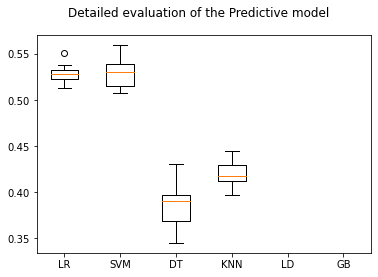

In [208]:
fg = plt.figure()
fg.suptitle('Detailed evaluation of the Predictive model')
x = fg.add_subplot(111)
plt.boxplot(out)
x.set_xticklabels(mode)
plt.show()